<a href="https://colab.research.google.com/github/samuel-mota-data/samuel-mota-data/blob/main/Projeto%3A%20Sistema%20de%20Recomenda%C3%A7%C3%A3o%20de%20Produtos%20da%20Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto: Sistema de Recomendação de Produtos da Amazon**


Bem-vindo(a) ao projeto sobre sistemas de recomendação. Trabalharemos com o conjunto de dados de notas atribuídas a produtos da Amazon neste projeto. O conjunto de dados contém as notas atribuídas a diferentes produtos eletrônicos. Ele não inclui informações sobre os produtos ou avaliações para evitar que haja viés durante a construção do modelo.

--------------
## **Contexto:**
--------------

Atualmente, a informação está crescendo exponencialmente em volume, velocidade e variedade em todo o mundo. Isso tem levado a uma sobrecarga de informações e a muitas opções para o consumidor de qualquer empresa. Isso representa um verdadeiro dilema para esses consumidores, e eles frequentemente recorrem à negação. Os sistemas de recomendação são uma das melhores ferramentas que ajudam a recomendar produtos aos consumidores enquanto eles navegam on-line. Fornecer recomendações personalizadas, que sejam mais relevantes para os usuários, é o que tem mais chance de mantê-los engajados e ajudar a empresa.

Sites de e-commerce, como Amazon, Walmart, Target e Etsy, usam diferentes modelos de recomendação para fornecer sugestões personalizadas para diferentes usuários. Essas empresas gastam milhões de dólares para elaborar técnicas algorítmicas que possam fornecer recomendações personalizadas a seus usuários.

A Amazon, por exemplo, é conhecida por sua seleção acurada de recomendações em seu site on-line. O sistema de recomendação da Amazon é capaz de analisar e prever de forma inteligente as preferências de compra dos clientes para oferecer a eles uma lista de produtos recomendados. O algoritmo de recomendação da Amazon é, portanto, um elemento essencial no uso da IA para melhorar a personalização de seu site. Por exemplo, um dos modelos de recomendação padrão que a Amazon utiliza é o de filtragem colaborativa item-item, que escala para conjuntos de dados massivos e produz recomendações de alta qualidade em tempo real.

----------------
## **Objetivo:**
----------------

Você é o gerente de ciência de dados da Amazon e recebeu a tarefa de criar um sistema de recomendação para recomendar produtos aos clientes com base nas notas que eles atribuíram a outros produtos anteriormente. Você tem uma coleção de dados rotulados de notas atribuídas a produtos da Amazon. O objetivo é extrair insights relevantes dos dados e criar um sistema de recomendação que ajude a recomendar produtos para consumidores on-line.

------------------------
## **Conjunto de dados:**
------------------------

O conjunto de dados da Amazon contém os seguintes atributos:

- **userId:** cada usuário é identificado com um id único.
- **productId:** cada produto é identificado com um id único.
- **Rating:** a nota do produto correspondente dada pelo usuário correspondente.
- **timestamp:** horário em que a nota foi atribuída. **Não usaremos esta coluna** para resolver o problema atual.

**Nota:** o código tem algumas funções definidas pelo usuário, que serão úteis ao sugerir recomendações e para medir o desempenho do modelo. Você pode usar essas funções ou criar suas próprias funções.

Às vezes, a instalação da biblioteca "Surprise", usada para criar sistemas de recomendação, gera problemas no Jupyter. Para evitar quaisquer problemas, é aconselhável utilizar o **Google Colab** neste projeto.

Começaremos montando o Google Drive no Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/ratings_Electronics.csv')

Mounted at /content/ratings_Electronics.csv


**Instalando a biblioteca "Surprise"**

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163760 sha256=a765729bcf7355915133f2c400a6e77ec6b3da13d528f578252ce69db2fb2b03
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## **Importando as bibliotecas necessárias e visão geral do conjunto de dados**

In [ ]:
# Basic python libraries
import numpy as np
import pandas as pd

# Python libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict

# For implementing cross validation
from surprise.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

### **Carregando os dados**
- Importe o conjunto de dados.
- Adicione os nomes das colunas ['user_id', 'prod_id', 'rating', 'timestamp'].
- Descarte a coluna de timestamp.
- Copie os dados para outro DataFrame, chamado **df**.

In [ ]:
# prompt: carregue os dados do caminho /content/sample_data/ratings_Electronics.csv

df = pd.read_csv('/content/sample_data/ratings_Electronics.csv', names=['user_id', 'prod_id', 'rating', 'timestamp'])
df.drop('timestamp', axis=1, inplace=True)
df.head()


FileNotFoundError: ignored

**Como este conjunto de dados é muito extenso, tendo 7 824 482 observações, não é computacionalmente possível criar um modelo com ele. Além disso, muitos usuários atribuíram nota apenas a alguns produtos, e alguns produtos tiveram notas atribuídas por pouquíssimos usuários. Logo, podemos reduzir o conjunto de dados considerando certas suposições lógicas.**

Neste caso, consideraremos os usuários que atribuíram pelo menos 50 notas (ratings) e os produtos que têm pelo menos cinco notas (ratings) atribuídas, uma vez que, ao comprar on-line, preferimos ter um certo número de avaliações (notas) atribuídas a um produto.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

## **Análise Exploratória dos Dados**

### **Forma dos dados**

### **Verifique o número de linhas e colunas e forneça observações.**

In [ ]:

print("O número de linhas inicial é:", df.shape[0])
print("O número de colunas inicial é:", df.shape[1])
print("O número de linhas final é:", df_final.shape[0])
print("O número de colunas final é:", df_final.shape[1])

O número de linhas inicial é: 125871
O número de colunas inicial é: 3
O número de linhas final é: 65290
O número de colunas final é: 3


**Escreva suas observações aqui:  **
- Os dados de avaliação inicial contêm **125.871** observações e **3** colunas.
- Os dados de avaliação final contêm **65.290** observações e **3** colunas.
- Os dados foram filtrados para melhorar o custo computacional.

### **Tipos de dados**

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Escreva suas observações aqui:**
- As colunas **"user_id"** e **"prod_id"** são ambas do **tipo objeto**.
- A coluna **"rating"** é do tipo **numérico** de dados.

### **Verificação de valores ausentes**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Escreva suas observações aqui:**
- Não há valores ausentes nos dados filtrados.

### **Resumo das estatísticas**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df['rating'].describe()

count    125871.000000
mean          4.261339
std           1.062144
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64

**Escreva suas observações aqui:**
- **Contagem:** 125.871 avaliações.
  
- **Média:** Aproximadamente 4,26, indicando avaliações geralmente positivas.

- **Desvio Padrão:** Cerca de 1,06, mostrando alguma variabilidade nas avaliações.

- **Mínimo:** Avaliação mínima de 1, indicando diversidade de opiniões.

- **25º Percentil:** 25% das avaliações são 4 ou menos.

- **Mediana:** 5, indicando que metade das avaliações são 5 ou menos.

- **75º Percentil:** 75% das avaliações são 5 ou menos.

- **Máximo:** Avaliação máxima de 5, sugerindo que 5 é a avaliação mais comum.

**Resumo:**
O conjunto de dados reflete avaliações positivas (média de 4,26) com alguma variabilidade. A diversidade é evidente pelo mínimo de 1. A maioria das avaliações está no topo (mediana e 75º percentil).

### **Verificando a distribuição das notas atribuídas**

In [ ]:
df['rating'].value_counts()

5.0    71034
4.0    32295
3.0    12060
2.0     5367
1.0     5115
Name: rating, dtype: int64

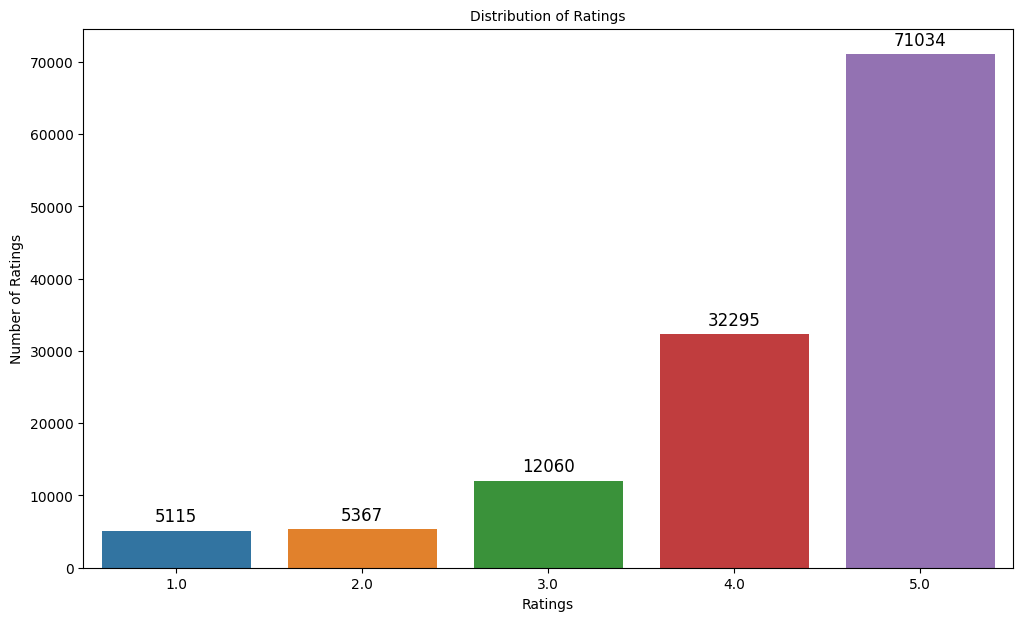

In [ ]:
# Create the bar plot of distribution of ratings and provide observations
plt.figure(figsize=(12, 7))
ax = sns.countplot(x="rating", data=df)

plt.tick_params(labelsize=10)
plt.title("Distribution of Ratings", fontsize=10)
plt.xlabel("Ratings", fontsize=10)
plt.ylabel("Number of Ratings", fontsize=10)

# Adicionando o texto da contagem de ratings nas barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

plt.show()

**Escreva suas observações aqui:**
- Aqui esta a distribuição das avaliações:
- **"5"**, com cerca de **70 mil** observações;
- **"4"**, com  cerca de **30 mil** observações;
- **"3"**, com cerca de **12 mil** observações;
- **"2"**, com cerca de **5 mil** observações;
- **"1"**, com cerca de **5 mil** observações.

### **Verificando o número de usuários e itens únicos no conjunto de dados**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
df['user_id'].nunique()

1540

In [ ]:
df['prod_id'].nunique()

48190

**Escreva suas observações aqui:**
- Existem **1 540 usuários** no conjunto de dados.
- Existem **48 190 produtos** no conjunto de dados.

### **Usuários com o maior número de notas atribuídas**

In [ ]:
# Top 10 users based on the number of ratings
df.groupby('user_id')['rating'].count().sort_values(ascending=False).head(10)

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
ARBKYIVNYWK3C     296
Name: rating, dtype: int64

**Escreva suas observações aqui:**
- O usuário **A5JLAU2ARJ0BO** tem a maior quantidade de **avaliações**, **520** notas atribuídas.

**Agora que exploramos e preparamos os dados, criaremos o primeiro sistema de recomendação.**

## **Modelo 1: Sistema de Recomendação Baseado em Classificação**

In [ ]:
# Calculate the average rating for each product
average_ratings = df.groupby('prod_id')['rating'].mean()
print("Média das Avaliações:")
print(average_ratings)

# Calculate the count of ratings for each product
rating_counts = df.groupby('prod_id')['rating'].count()
print("\nContagem de Avaliações:")
print(rating_counts)

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'média_avaliação': average_ratings, 'contagem_avaliações': rating_counts})
print("\nDataFrame de Avaliações Final:")
print(final_rating)

# Sort the dataframe by average of ratings in descending order
final_rating = final_rating.sort_values(by='média_avaliação', ascending=False)
print("\nDataFrame de Avaliações Final (Ordenado):")
print(final_rating)

# See the first five records of the "final_rating" dataset
print(final_rating.head())

Média das Avaliações:
prod_id
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
                ...   
B00LED02VY    4.000000
B00LGN7Y3G    5.000000
B00LGQ6HL8    5.000000
B00LI4ZZO8    4.500000
B00LKG1MC8    5.000000
Name: rating, Length: 48190, dtype: float64

Contagem de Avaliações:
prod_id
0594451647    1
0594481813    1
0970407998    2
0972683275    4
1400501466    6
             ..
B00LED02VY    1
B00LGN7Y3G    1
B00LGQ6HL8    5
B00LI4ZZO8    2
B00LKG1MC8    1
Name: rating, Length: 48190, dtype: int64

DataFrame de Avaliações Final:
            média_avaliação  contagem_avaliações
prod_id                                         
0594451647         5.000000                    1
0594481813         3.000000                    1
0970407998         2.500000                    2
0972683275         4.750000                    4
1400501466         3.333333                    6
...                     ...                  ..

In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def get_top_n_products(df, n, min_interactions=10):
    # Calculate the average rating for each product
    average_ratings = df.groupby('prod_id')['rating'].mean()

    # Calculate the count of ratings for each product
    rating_counts = df.groupby('prod_id')['rating'].count()

    # Create a DataFrame with calculated average and count of ratings
    final_rating = pd.DataFrame({'average_rating': average_ratings, 'rating_count': rating_counts})

# Finding products with minimum number of interactions
    # Filter products with at least min_interactions interactions
    final_rating = final_rating[final_rating['rating_count'] >= min_interactions]
# Sorting values with respect to average rating
  # Sort the DataFrame by average rating in descending order
    final_rating = final_rating.sort_values(by='average_rating', ascending=False)

    # Get the top n products
    top_n_products = final_rating.head(n)

    return top_n_products

# Example usage:
top_n_products = get_top_n_products(df, n=10, min_interactions=5)
print("Top 10 products based on highest average rating and at least 5 interactions:")
print(top_n_products)

Top 10 products based on highest average rating and at least 5 interactions:
            average_rating  rating_count
prod_id                                 
B00LGQ6HL8             5.0             5
B003DZJQQI             5.0            14
B005FDXF2C             5.0             7
B00I6CVPVC             5.0             7
B00B9KOCYA             5.0             8
B003CK10DG             5.0             5
B003B41XYO             5.0             5
B0007WK8KS             5.0             6
B0084FM5JC             5.0             5
B005GI2VMG             5.0            10


### **Recomendando os cinco principais produtos com, no mínimo, 50 interações com base na popularidade**

In [ ]:
# prompt: Recomendando os cinco principais produtos com, no mínimo, 50 interações com base na popularidade

top_5_products_50_min = get_top_n_products(df, n=5, min_interactions=50)
print(top_5_products_50_min)


            average_rating  rating_count
prod_id                                 
B001TH7GUU        4.871795            78
B003ES5ZUU        4.864130           184
B0019EHU8G        4.855556            90
B006W8U2MU        4.824561            57
B000QUUFRW        4.809524            84


### **Recomendando os cinco principais produtos com, no mínimo, 100 interações com base na popularidade**

In [ ]:
# prompt: Recomendando os cinco principais produtos com, no mínimo, 100 interações com base na popularidade

top_5_products_100_min = get_top_n_products(df, n=5, min_interactions=100)
print(top_5_products_100_min)


            average_rating  rating_count
prod_id                                 
B003ES5ZUU        4.864130           184
B000N99BBC        4.772455           167
B002WE6D44        4.770000           100
B007WTAJTO        4.701220           164
B002V88HFE        4.698113           106


Recomendamos os **cinco principais** produtos usando o sistema de recomendação de popularidade. Agora, criaremos um sistema de recomendação usando a **filtragem colaborativa.**

## **Modelo 2: Sistema de Recomendação de Filtragem Colaborativa**

### **Criando um sistema de recomendação de referência baseado em similaridade usuário-usuário**

- Abaixo, estamos criando **sistemas de recomendação baseados em similaridade**, usando a similaridade `cosine` (cosseno), e utilizando o **KNN para encontrar usuários semelhantes**, que são os vizinhos mais próximos do usuário em questão.
- Usaremos uma nova biblioteca, chamada `surprise`, para criar os demais modelos. Primeiro, importaremos as classes e funções necessárias dessa biblioteca.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Antes de criarmos os sistemas de recomendação, revisaremos algumas terminologias básicas que usaremos:**

**Item relevante:** um item (produto, neste caso) cuja **avaliação real é maior que a avaliação de referência (limite)** é considerado relevante. Se a **avaliação real estiver abaixo da referência, então o item é considerado não relevante**.

**Item recomendado:** um item cuja **avaliação prevista é maior que a avaliação de referência é considerado um item recomendado**. Se a **avaliação prevista estiver abaixo da referência, tal produto não será recomendado ao usuário**.

**Falso negativo (FN):** é a **frequência de itens relevantes que não são recomendados ao usuário**. Se os itens relevantes não forem recomendados ao usuário, é possível que o usuário não compre o produto/item. Isso resultaria em **perda de oportunidade para o prestador do serviço**, algo que ele gostaria de minimizar.

**Falso positivo (FP):** é a **frequência de itens recomendados que, na verdade, não são relevantes**. Nesse caso, o sistema de recomendação não está fazendo um bom trabalho no que diz respeito à localização e recomendação de itens relevantes para o usuário. Isso resultaria em **perda de recursos para o prestador do serviço**, algo que ele também gostaria de minimizar.

**Recall:** é a **fração de itens realmente relevantes que são recomendados ao usuário**. Por exemplo, se de dez produtos relevantes, seis são recomendados para o usuário, o recall é de 0.6. Quanto maior é o valor do recall, melhor é o modelo. É uma das métricas usadas para avaliar o desempenho dos modelos de classificação.

**Precisão:** é a **fração de itens recomendados que são realmente relevantes**. Por exemplo, se de dez itens recomendados, seis são considerados relevantes pelo usuário, a precisão é de 0.6. Quanto maior é o valor da precisão, melhor é o modelo. É uma das métricas usadas para avaliar o desempenho dos modelos de classificação.

**Ao criar um sistema de recomendação, costuma-se observar o desempenho do modelo. Em termos de quantas recomendações são relevantes, e vice-versa, abaixo estão algumas das métricas de desempenho mais usadas na avaliação de sistemas de recomendação.**

### **Precision@k, Recall@k e F1-score@k**

**Precision@k**: é a **fração de itens recomendados que são relevantes nas `top k` (k principais) previsões**. O valor de k é o número de recomendações a serem fornecidas ao usuário. Pode-se escolher um número variável de recomendações a serem fornecidas a um único usuário.


**Recall@k**: é a **fração de itens relevantes que são recomendados ao usuário nas `top k` (k principais) previsões**.

**F1-score@k**: é a **média harmônica de Precision@k e Recall@k**. Quando **tanto precision@k quanto recall@k parecem ser importantes**, é útil usar essa métrica, pois é representativa de ambas.

### **Algumas funções úteis**

- A função abaixo recebe o **modelo de recomendação** como entrada e fornece **precision@k, recall@k e F1-score@k** para esse modelo.
- Para calcular a **precisão** e o **recall**, as **k principais** previsões são consideradas para cada usuário.
- Usaremos a precisão e o recall para calcular o F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Dicas:**

- Para calcular a **precisão** e o **recall**, uma **referência de 3.5 e um valor de k igual a 10 podem ser considerados para as avaliações recomendadas e relevantes**.
- Pense na métrica de desempenho a ser escolhida.

Abaixo, estamos carregando o **conjunto de dados de** **`rating`**, que é um **DataFrame do pandas**, em um **formato diferente chamado `surprise.dataset.DatasetAutoFolds`**, que é exigido por essa biblioteca. Para isso, **utilizaremos as classes `Reader` e `Dataset`.**

In [ ]:
from sklearn.preprocessing import LabelEncoder
data=df[['user_id','prod_id']].apply(LabelEncoder().fit_transform)
data['rating']=df['rating']
data.head()

,user_id,prod_id,rating
94,942,0,5.0
118,1461,1,3.0
177,850,2,1.0
178,82,2,4.0
492,950,3,5.0


In [ ]:
df_rating = data.copy()

In [ ]:
# Calculating average ratings
average_rating = data.groupby('prod_id').mean()['rating']

# Calculating the count of ratings
count_rating = data.groupby('prod_id').count()['rating']

# Updating the final_rating dataframe with the new encoded book_id count and average of ratings based on the new dataframe
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})
final_rating.head()

,avg_rating,rating_count
prod_id,,
0,5.000000,1
1,3.000000,1
2,2.500000,2
3,4.750000,4
4,3.333333,6


In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 10))

# Loading the rating dataset
data = Dataset.load_from_df(data[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Agora, estamos **prontos para criar o primeiro sistema de recomendação de referência baseado em similaridade** usando a similaridade de cosseno.

### **Criando o Sistema de Recomendação Baseado em Similaridade Usuário-Usuário**

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Fit the model on the training data
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(algo_knn_user)

RMSE: 1.1067
Precision:  0.847
Recall:  0.718
F_1 score:  0.777


**Escreva suas observações aqui:**

- Ao analisarmos o desempenho do modelo de referência, observamos que possui um **`RMSE`** de **1.1067** no conjunto de teste.
- Na interpretação do `recall`, constatamos um valor de aproximadamente *0.718*, o que significa que **de todos os produtos relevantes, 71.8% são recomendados**.
- Em relação à `precisão`, verificamos um valor de aproximadamente *0.847*, indicando que **de todos os produtos recomendados, 84.7% são relevantes**.
- A `F_1 score` do modelo de referência é cerca de *0.777*, sugerindo que **a maioria dos produtos recomendados era relevante e que produtos relevantes foram recomendados**.

Agora, **preveremos a avaliação para o usuário com `userId=A3LDPF5FMB782Z` e o `productId=1400501466`**, conforme mostrado abaixo. Neste caso, o usuário já interagiu ou viu o produto com productId "1400501466" e atribuiu uma nota 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict('A3LDPF5FMB782Z', 1400501466, r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=5, est=4.263416620322555, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Escreva suas observações aqui:**
- Observamos que a avaliação real para este par usuário-item é **5**, sendo a avaliação prevista por este modelo de referência baseado em similaridade igual a **4.26**, o que não é muito bom.

Abaixo, está a **lista de usuários que não viram o produto com productId "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
df[df['prod_id'] != '1400501466']['user_id'].unique()

array(['A3BY5KCNQZXV5U', 'AT09WGFUM934H', 'A32HSNCNPRUMTR', ...,
       'AT53ZTTO707MB', 'A1X3ESYZ79H59E', 'A328S9RN3U5M68'], dtype=object)

* Pode-se observar na lista acima que **o usuário "A3BY5KCNQZXV5U"** não viu o produto com productId **"1400501466"**, pois esse userId faz parte da lista acima.

**Abaixo, estamos prevendo a avaliação/nota para `userId=A3BY5KCNQZXV5U` e `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict('A3BY5KCNQZXV5U', 1400501466, verbose=True)

user: A3BY5KCNQZXV5U item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3BY5KCNQZXV5U', iid=1400501466, r_ui=None, est=4.263416620322555, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Escreva suas observações aqui:**
- A avaliação prevista do usuário **A3BY5KCNQZXV5U** por este modelo de referência baseado em similaridade igual a **4.26**

### **Melhorando o sistema de recomendação baseado em similaridade ajustando seus hiperparâmetros**

Abaixo, estaremos ajustando hiperparâmetros para o algoritmo `KNNBasic`. Vamos entender alguns dos hiperparâmetros do algoritmo KNNBasic:

- **k** (int): o número (máximo) de vizinhos a serem considerados para agregação. O padrão é 40.
- **min_k** (int): o número mínimo de vizinhos a serem considerados para agregação. Se não houver vizinhos suficientes, a previsão é definida como a média global de todas as avaliações (notas). O padrão é 1.
- **sim_options** (dict): um dicionário de opções para a medida de similaridade. E há quatro medidas de similaridade disponíveis em Surprise:
    - cosseno
    - msd (distância média quadrática, padrão)
    - Pearson
    - baseline de Pearson

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [4, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
# Fitting the data
gs.fit(data)
# Best RMSE score
print(gs.best_score['rmse'])
# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0532045098026026
{'k': 40, 'min_k': 4, 'sim_options': {'name': 'cosine', 'user_based': True}}


Assim que a busca em grade (grid search) estiver **concluída**, podemos obter os **valores ideais para cada um desses hiperparâmetros**.

Agora, criaremos o **modelo final usando os valores ajustados dos hiperparâmetros** que recebemos usando a **busca em grade com validação cruzada**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options_2 = {'name': 'msd',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options_2=sim_options_2, k=40, min_k=4, verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=6.
precision_recall_at_k(similarity_algo_optimized)

RMSE: 1.0512
Precision:  0.838
Recall:  0.721
F_1 score:  0.775


O modelo ajustado apresentou melhorias significativas em relação ao modelo de referência:

1. **RMSE (Root Mean Square Error):**
   - Modelo Ajustado: **1.0512** (melhoria em relação a **1.1089** no modelo de referência).

2. **Precision:**
   - Modelo Ajustado: **0.838** (ligeira redução em relação a **0.858** no modelo de referência).

3. **Recall:**
   - Modelo Ajustado: **0.721** (aumento substancial em relação a **0.516** no modelo de referência).

4. **F-1 Score:**
   - Modelo Ajustado: **0.775** (melhoria em relação a **0.644** no modelo de referência).

Em resumo, o ajuste de hiperparâmetros resultou em um modelo mais preciso, evidenciado pela redução no RMSE, e mais equilibrado, indicado pelo aumento no recall e F-1 score. Apesar de uma pequena diminuição na precisão, as melhorias globais sugerem benefícios significativos no modelo ajustado.

### **Passos:**
- **Prever a nota para o usuário com `userId="A3LDPF5FMB782Z"` e o `prod_id= "1400501466"` usando o modelo otimizado.**
- **Prever a nota para o usuário com `userId="A34BZM6S9L7QI4"`, que não interagiu com o `prod_id ="1400501466"`, usando o modelo otimizado.**
- **Comparar a saída com a saída do modelo de referência.**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict('A3LDPF5FMB782Z', 1400501466, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3LDPF5FMB782Z', iid=1400501466, r_ui=None, est=4.263416620322555, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3BY5KCNQZXV5U" and productId "1400501466"
similarity_algo_optimized.predict('A3BY5KCNQZXV5U', 1400501466, verbose=True)

user: A3BY5KCNQZXV5U item: 1400501466 r_ui = None   est = 4.26   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}


Prediction(uid='A3BY5KCNQZXV5U', iid=1400501466, r_ui=None, est=4.263416620322555, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'})

**Escreva suas observações aqui:**
- Não há diferença na previsão do modelo de referência e do modelo ajustado para esse par usuário-item específico. Ambos os modelos previram a avaliação como **4.26**, muito distante da real, igual a **5**.
- Provavelmente o modelo está **''overfitando''** porque mesmo mudando os usuários o valor **não** sofre alteração considerável.

### **Identificando usuários semelhantes a um determinado usuário (vizinhos mais próximos)**

Também podemos descobrir **usuários semelhantes a um determinado usuário** ou seus **vizinhos mais próximos** com base neste algoritmo KNNBasic. Abaixo, encontramos os cinco usuários mais semelhantes ao primeiro usuário da lista com id interno 0, com base na métrica de distância `msd`.

In [ ]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)

[5, 8, 19, 22, 25]

### **Implementação do algoritmo de recomendação baseado no modelo KNNBasic otimizado**

Abaixo, implementaremos uma função, na qual os parâmetros de entrada são:

- data: conjunto de dados de avaliações/notas (**rating**).
- user_id: id do usuário **em relação ao qual desejamos as recomendações**.
- top_n: **número de produtos que queremos recomendar**.
- algo: algoritmo que queremos usar **para prever as avaliações/notas**.
- A saída da função é um **conjunto de top_n itens** recomendado para o dado user_id com base no algoritmo fornecido.

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user



```
# Isto está formatado como código
```

**Prevendo os cinco principais produtos para o userId = "A3LDPF5FMB782Z" com sistema de recomendação baseado em similaridade**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine

get_recommendations(df, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized)


[('0594451647', 4.263416620322555),
 ('0594481813', 4.263416620322555),
 ('0970407998', 4.263416620322555),
 ('0972683275', 4.263416620322555),
 ('1400532620', 4.263416620322555)]

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"

df_recommendations = pd.DataFrame(get_recommendations(df, 'A3LDPF5FMB782Z', 5, similarity_algo_optimized), columns = ['prod_id', 'predicted_ratings'])
df_recommendations

,prod_id,predicted_ratings
0,0594451647,4.263417
1,0594481813,4.263417
2,0970407998,4.263417
3,0972683275,4.263417
4,1400532620,4.263417


### **Sistema de Recomendação de Filtragem Colaborativa Baseada em Similaridade Item-Item**

* Acima, vimos a **filtragem colaborativa baseada em similaridade**, na qual a similaridade é calculada **entre usuários**. Agora, analisaremos a filtragem colaborativa baseada em similaridade, na qual a similaridade é examinada **entre os itens**.

In [ ]:
# Declaring the similarity options

# KNN algorithm is used to find desired similar items. Use random_state=1

# Train the algorithm on the trainset, and predict ratings for the test set

# Let us compute precision@k, recall@k, and f_1 score with k = 10


In [ ]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy

small_trainset, small_testset = train_test_split(data, test_size=0.1, random_state=1)
# Dividindo os dados em conjunto de treinamento e teste
trainset, testset = train_test_split(data, test_size=.30, random_state=1)

# Configurando o algoritmo KNN
sim_options = {
    'name': 'cosine',  # medida de similaridade
    'user_based': False  # item-item
}
algo = KNNWithMeans(sim_options=sim_options)

# Treinando o algoritmo
algo.fit(small_trainset)

# Fazendo previsões no conjunto de teste
predictions = algo.test(small_testset)

# Calculando e imprimindo as métricas de avaliação
precision = accuracy.precision(predictions, k=10)
recall = accuracy.recall(predictions, k=10)
f1 = 2 * (precision * recall) / (precision + recall)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

**Escreva suas observações aqui:**____________

Agora, **preveremos uma avaliação/nota para o usuário com `userId = A3LDPF5FMB782Z` e o `prod_Id = 1400501466`**, conforme mostrado abaixo. Neste caso, o usuário já interagiu ou viu o produto com productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product


**Escreva suas observações aqui:**____________

Abaixo, estamos **prevendo a avaliação/nota para o `userId = A34BZM6S9L7QI4` e o `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product


**Escreva suas observações aqui:**____________

### **Ajuste de hiperparâmetros do modelo baseado em similaridade item-item**
- Use os seguintes valores para a grade de parâmetros (param_grid) e ajuste o modelo.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() para ajustar o modelo usando a medida RMSE.
- Imprima o melhor escore e os melhores parâmetros.

In [ ]:
# Setting up parameter grid to tune the hyperparameters

# Performing 3-fold cross validation to tune the hyperparameters

# Fitting the data

# Find the best RMSE score

# Find the combination of parameters that gave the best RMSE score


Assim que a **busca em grade (grid search)** estiver concluída, podemos obter os **valores ideais para cada um desses hiperparâmetros, conforme mostrado acima**.

Agora, criaremos o **modelo final** usando os **valores ajustados dos hiperparâmetros** que recebemos usando a **busca em grade com validação cruzada**.

### **Use os melhores parâmetros do GridSearchCV para criar o modelo baseado em similaridade item-item otimizado. Compare o desempenho do modelo otimizado com o do modelo de referência.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering

# Creating an instance of KNNBasic with optimal hyperparameter values

# Training the algorithm on the trainset

# Let us compute precision@k and recall@k, f1_score and RMSE


**Escreva suas observações aqui:__________**

### **Passos:**
- **Prever a avaliação/nota para o usuário com `userId="A3LDPF5FMB782Z"` e o `prod_id= "1400501466"` usando o modelo otimizado.**
- **Prever a avaliação/nota para o usuário com `userId="A34BZM6S9L7QI4"`, que não interagiu com o `prod_id ="1400501466"`, usando o modelo otimizado.**
- **Comparar a saída com a saída do modelo de referência.**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"


In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"


**Escreva suas observações aqui:__________**

### **Identificando itens semelhantes a um determinado item (vizinhos mais próximos)**

Também podemos descobrir **itens semelhantes** a um determinado item ou seus vizinhos mais próximos com base neste **algoritmo KNNBasic**. Abaixo, encontramos os cinco itens mais semelhantes ao item com id interno 0, com base na métrica de distância `msd`.

**Previsão dos cinco principais produtos para o userId = "A1A5KUIIIHFF4U" com o sistema de recomendação baseado em similaridade.**

**Dica:** use a função get_recommendations().

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.


In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"


Agora, como vimos **algoritmos de filtragem colaborativa baseados em similaridade**, trataremos de **algoritmos de filtragem colaborativa baseados em modelo**.

### **Modelo 3: Filtragem Colaborativa Baseada em Modelo: Fatoração de Matrizes**

A Filtragem Colaborativa Baseada em Modelo é um **sistema de recomendação personalizado**. As recomendações são baseadas no comportamento passado do usuário e não dependem de informações adicionais. Usamos **recursos latentes** para encontrar recomendações para cada usuário.

### Decomposição em Valores Singulares (SVD)

SVD é usado para **computar os recursos latentes** da **matriz item-usuário**, mas não funciona quando **há valores ausentes** na **matriz item-usuário**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1

# Training the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


**Escreva suas observações aqui:___________**

**Agora, preveremos a avaliação/nota para o usuário com `userId = "A3LDPF5FMB782Z"` e o `prod_id = "1400501466`.**

In [ ]:
# Making prediction


**Escreva suas observações aqui:___________**

**Abaixo, estamos prevendo a avaliação/nota para o `userId = "A34BZM6S9L7QI4"` e o `productId = "1400501466"`.**

In [ ]:
# Making prediction


**Escreva suas observações aqui:___________**

### **Melhorando o sistema de recomendação baseado em fatoração de matrizes ajustando seus hiperparâmetros**

Abaixo, ajustaremos apenas três hiperparâmetros:
- **n_epochs**: número de iterações do algoritmo SGD (Gradiente Descendente Estocástico).
- **lr_all**: taxa de aprendizado para todos os parâmetros.
- **reg_all**: termo de regularização para todos os parâmetros.

In [ ]:
# Set the parameter space to tune

# Performing 3-fold gridsearch cross-validation

# Fitting data

# Best RMSE score

# Combination of parameters that gave the best RMSE score


Agora, **criaremos o modelo final** usando os **valores ajustados** dos hiperparâmetros que recebemos usando a validação cruzada da busca em grade acima.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1

# Train the algorithm on the trainset

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE


**Escreva suas observações aqui:_____________**

### **Passos:**
- **Prever a avaliação/nota para o usuário com `userId="A3LDPF5FMB782Z"` e o `prod_id= "1400501466"` usando o modelo otimizado.**
- **Prever a avaliação/nota para o `userId="A34BZM6S9L7QI4"`, que não interagiu com `prod_id ="1400501466"`, usando o modelo otimizado.**
- **Comparar a saída com a saída do modelo de referência.**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"


In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"


### **Conclusão e Recomendações**

**Escreva sua conclusão e suas recomendações nesta parte.**